In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import re
import random
import os
import pickle

In [3]:

%matplotlib inline

import numpy as np
np.random.seed(6788)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.set_random_seed(6788)

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, SimpleRNN, Activation, dot, concatenate, Bidirectional
from keras.models import Model, load_model

from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

Using TensorFlow backend.


In [4]:
MAX_LENGTH = 200
MIN_WORD_COUNT = 3
MAX_WORD_COUNT = 8

In [5]:
def normalize_string(s):
    s = re.sub(r"([.!?])", r" \1", s)
    return s


def filter_pair(p, ignore_list=[]):
     return MAX_WORD_COUNT >= len(p[0].split(' ')) >= MIN_WORD_COUNT and \
        len(p[0]) <= MAX_LENGTH and \
        not p[0] in ignore_list


def filter_pairs(pairs, ignore_list=[]):
    return [pair for pair in pairs if filter_pair(pair, ignore_list)]


def read_from_file(path):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(path, encoding='utf-16'). \
        read().strip().split('\n')

    # Split every line into data and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    return pairs


def prepare_data(path, ignore_list=[]):
    pairs = read_from_file(path)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs, ignore_list)
    print("Trimmed to %s sentence pairs" % len(pairs))
    return pairs

In [6]:
training_pairs = prepare_data("./data/all_corpus_sentence_pairs_v6.txt")
input_data = [row[0] for row in training_pairs]
output_data = [row[1] for row in training_pairs]

Reading lines...
Read 154014 sentence pairs
Trimmed to 154014 sentence pairs


In [7]:
# Placeholder for max lengths of input and output which are user configurable constants
max_input_length = None
max_output_length = None

char_start_encoding = 1
char_padding_encoding = 0


def build_sequence_encode_decode_dicts(input_data):
    encoding_dict = {}
    decoding_dict = {}
    for line in input_data:
        for char in line:
            if char not in encoding_dict:
                # Using 2 + because our sequence start encoding is 1 and padding encoding is 0
                encoding_dict[char] = 2 + len(encoding_dict)
                decoding_dict[2 + len(decoding_dict)] = char

    return encoding_dict, decoding_dict, len(encoding_dict) + 2

In [8]:
def encode_sequences(encoding_dict, sequences, max_length):
    encoded_data = np.zeros(shape=(len(sequences), max_length))
    for i in range(len(sequences)):
        for j in range(min(len(sequences[i]), max_length)):
            encoded_data[i][j] = encoding_dict[sequences[i][j]]
    return encoded_data

In [9]:
def decode_sequence(decoding_dict, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += decoding_dict[i]
    return text

In [10]:
def generate(text, input_encoding_dict, model, max_input_length, max_output_length, beam_size, max_beams,
             min_cut_off_len, cut_off_ratio):
    min_cut_off_len = max(min_cut_off_len, cut_off_ratio * len(text))
    min_cut_off_len = min(min_cut_off_len, max_output_length)

    encoder_input = encode_sequences(input_encoding_dict, [text], max_input_length)

    completed_beams = []
    running_beams = [
        [np.zeros(shape=(len(encoder_input), max_output_length)), [1]]
    ]
    running_beams[0][0][:, 0] = char_start_encoding

    while len(running_beams) != 0:
        running_beams = sorted(running_beams, key=lambda tup: np.prod(tup[1]), reverse=True)
        running_beams = running_beams[:max_beams]

        temp_running_beams = []
        for running_beam, probs in running_beams:
            if len(probs) >= min_cut_off_len:
                completed_beams.append([running_beam[:, 1:], probs])
            else:
                prediction = model.predict([encoder_input, running_beam])[0]
                sorted_args = prediction.argsort()
                sorted_probs = np.sort(prediction)

                for i in range(1, beam_size + 1):
                    temp_running_beam = np.copy(running_beam)
                    i = -1 * i
                    ith_arg = sorted_args[:, i][len(probs)]
                    ith_prob = sorted_probs[:, i][len(probs)]

                    temp_running_beam[:, len(probs)] = ith_arg
                    temp_running_beams.append([temp_running_beam, probs + [ith_prob]])

        running_beams = [b for b in temp_running_beams]

    return completed_beams

In [11]:
def infer(text, model, params, beam_size=3, max_beams=3, min_cut_off_len=10, cut_off_ratio=1.5):
    input_encoding_dict = params['input_encoding']
    output_decoding_dict = params['output_decoding']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    decoder_outputs = generate(text, input_encoding_dict, model, max_input_length, max_output_length, beam_size,
                               max_beams, min_cut_off_len, cut_off_ratio)
    outputs = []
    for decoder_output, probs in decoder_outputs:
        outputs.append({'sequence': decode_sequence(output_decoding_dict, decoder_output[0]), 'prob': np.prod(probs)})

    return outputs

In [12]:
def generate_greedy(text, input_encoding_dict, model, max_input_length, max_output_length):
    encoder_input = encode_sequences(input_encoding_dict, [text], max_input_length)
    decoder_input = np.zeros(shape=(len(encoder_input), max_output_length))
    decoder_input[:, 0] = char_start_encoding
    for i in range(1, max_output_length):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:, i] = output[:, i]

        if decoder_input[:, i] == char_padding_encoding:
            return decoder_input[:, 1:]

    return decoder_input[:, 1:]

In [13]:
def infer_greedy(text, model, params):
    input_encoding_dict = params['input_encoding']
    output_decoding_dict = params['output_decoding']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    decoder_output = generate_greedy(text, input_encoding_dict, model, max_input_length, max_output_length)
    return decode_sequence(output_decoding_dict, decoder_output[0])

In [14]:
def build_params(input_data=[], output_data=[], params_path='test_params', max_lengths=(5, 5)):
    if os.path.exists(params_path):
        print('Loading the params file')
        params = pickle.load(open(params_path, 'rb'))
        return params

    print('Creating params file')
    input_encoding, input_decoding, input_dict_size = build_sequence_encode_decode_dicts(input_data)
    output_encoding, output_decoding, output_dict_size = build_sequence_encode_decode_dicts(output_data)
    params = {}
    params['input_encoding'] = input_encoding
    params['input_decoding'] = input_decoding
    params['input_dict_size'] = input_dict_size
    params['output_encoding'] = output_encoding
    params['output_decoding'] = output_decoding
    params['output_dict_size'] = output_dict_size
    params['max_input_length'] = max_lengths[0]
    params['max_output_length'] = max_lengths[1]

    os.makedirs(os.path.dirname(params_path), exist_ok=True)
    with open(params_path, 'wb') as f:
        pickle.dump(params, f)
    return params

In [15]:
def convert_training_data(input_data, output_data, params):
    input_encoding = params['input_encoding']
    input_decoding = params['input_decoding']
    input_dict_size = params['input_dict_size']
    output_encoding = params['output_encoding']
    output_decoding = params['output_decoding']
    output_dict_size = params['output_dict_size']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    encoded_training_input = encode_sequences(input_encoding, input_data, max_input_length)
    encoded_training_output = encode_sequences(output_encoding, output_data, max_output_length)
    training_encoder_input = encoded_training_input
    training_decoder_input = np.zeros_like(encoded_training_output)
    training_decoder_input[:, 1:] = encoded_training_output[:, :-1]
    training_decoder_input[:, 0] = char_start_encoding
    training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]
    x = [training_encoder_input, training_decoder_input]
    y = [training_decoder_output]
    return x, y

In [16]:
def build_model(params_path='test/params', enc_lstm_units=128, unroll=True):
    # generateing the encoding, decoding dicts
    params = build_params(params_path=params_path)

    input_encoding = params['input_encoding']
    input_decoding = params['input_decoding']
    input_dict_size = params['input_dict_size']
    output_encoding = params['output_encoding']
    output_decoding = params['output_decoding']
    output_dict_size = params['output_dict_size']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    print('Input encoding', input_encoding)
    print('Input decoding', input_decoding)
    print('Output encoding', output_encoding)
    print('Output decoding', output_decoding)

    # We need to define the max input lengths and max output lengths before training the model.
    # We pad the inputs and outputs to these max lengths
    encoder_input = Input(shape=(max_input_length,))
    decoder_input = Input(shape=(max_output_length,))

    # Need to make the number of hidden units configurable
    encoder = Embedding(input_dict_size, enc_lstm_units, input_length=max_input_length, mask_zero=True)(encoder_input)
    # using concat merge mode since in my experiments it gave the best results same with unroll
    encoder = Bidirectional(LSTM(enc_lstm_units, return_sequences=True, unroll=unroll), merge_mode='concat')(encoder)
    encoder_last = encoder[:, -1, :]

    # using 2* enc_lstm_units because we are using concat merge mode
    # cannot use bidirectionals lstm for decoding (obviously!)

    decoder = Embedding(output_dict_size, 2 * enc_lstm_units, input_length=max_output_length, mask_zero=True)(
        decoder_input)
    decoder = LSTM(2 * enc_lstm_units, return_sequences=True, unroll=unroll)(decoder,
                                                                             initial_state=[encoder_last, encoder_last])

    # luong attention
    attention = dot([decoder, encoder], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)

    context = dot([attention, encoder], axes=[2, 1])

    decoder_combined_context = concatenate([context, decoder])

    output = TimeDistributed(Dense(enc_lstm_units, activation="tanh"))(decoder_combined_context)
    output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)

    model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model, params

In [17]:
model, params = build_model(params_path='./checkpoints/params')

Loading the params file
Input encoding {'අ': 2, 'න': 3, 'ි': 4, 'ත': 5, '්': 6, ' ': 7, 'එ': 8, 'ව': 9, 'ු': 10, 'ස': 11, 'ා': 12, 'ණ': 13, 'හ': 14, '.': 15, 'ල': 16, 'ැ': 17, 'ය': 18, 'ක': 19, 'ම': 20, 'ර': 21, 'ේ': 22, 'ද': 23, 'ෙ': 24, 'ප': 25, '\u200d': 26, 'ඩ': 27, 'ඉ': 28, 'ග': 29, 'ආ': 30, 'ධ': 31, 'ං': 32, 'ට': 33, 'ෝ': 34, 'ඇ': 35, 'ඟ': 36, 'බ': 37, 'ඳ': 38, 'ී': 39, 'ථ': 40, 'ො': 41, 'ූ': 42, 'ඊ': 43, 'ළ': 44, 'භ': 45, 'ඛ': 46, 'ඒ': 47, 'ඔ': 48, 'ඬ': 49, 'ශ': 50, 'ෂ': 51, 'ඵ': 52, 'ජ': 53, 'ඨ': 54, 'ච': 55, 'ෑ': 56, 'උ': 57, 'ඝ': 58, 'ෞ': 59, 'ඥ': 60, 'ඡ': 61, 'ෘ': 62, 'ඈ': 63, 'ෛ': 64, 'ෆ': 65, 'ඤ': 66, 'ඕ': 67, 'ඹ': 68, 'ඓ': 69, 'ඪ': 70, 'ෲ': 71, 'ඌ': 72, 'ඖ': 73, '¸': 74, 'ඞ': 75, '‒': 76, 'ඍ': 77, 'ෟ': 78, 'ඣ': 79, '�': 80, '\xa0': 81, 'Ê': 82, 'ඃ': 83, '\u202c': 84, '\u0dfe': 85, '\x83': 86, '‚': 87, '\u2003': 88, '\x94': 89}
Input decoding {2: 'අ', 3: 'න', 4: 'ි', 5: 'ත', 6: '්', 7: ' ', 8: 'එ', 9: 'ව', 10: 'ු', 11: 'ස', 12: 'ා', 13: 'ණ', 14: 'හ', 15: '.', 16: 'ල', 17: 

In [18]:
model.load_weights('./checkpoints/checkpoint_weights.h5')

In [19]:
# loading sentences pairs needed for evaluation
# passing senteces used in training the model to ignore as 'ignore_list'
eval_pairs = prepare_data("./data/all_corpus_sentence_pairs_v6_evaluation.txt", ignore_list=input_data)
input_eval_data = [row[0] for row in eval_pairs]
output_eval_data = [row[1] for row in eval_pairs]

Reading lines...
Read 200 sentence pairs
Trimmed to 200 sentence pairs


In [20]:
# correct_predictions = number of correct predications made by the system
# incorrect_predictions = number of incorrect predications made by the system


def evaluate(input_sentences, output_sentences, model, params):
    correct_predictions = 0
    incorrect_predictions = 0
    contains_error = []
    error_predict = []
    for i in range(len(input_sentences)):
        input_sentence = input_sentences[i]
        output_sentence = output_sentences[i]
        predicted_sentence = infer_greedy(input_sentence, model, params)
        print('>', input_sentence)
        print('=', output_sentence)
        if output_sentence == predicted_sentence:
            correct_predictions += 1
            print('<', predicted_sentence)
        else:
            incorrect_predictions += 1
            print('[WRONG] <', predicted_sentence)
        print('')
        
        if input_sentence == output_sentence:
            contains_error.append(0)
            if input_sentence == predicted_sentence:
                error_predict.append(0)
            else:
                error_predict.append(1)
        else:
            contains_error.append(1)
            if input_sentence == predicted_sentence:
                error_predict.append(0)
            else:
                error_predict.append(1)
        
    return correct_predictions, incorrect_predictions, contains_error, error_predict

In [21]:
correct_predictions, incorrect_predictions, actual_errors, predict_errors = evaluate(input_eval_data, output_eval_data, model, params)

> මම සැමවිටම යාච්ඤා කරයි .
= මම සැමවිටම යාච්ඤා කරමි .
< මම සැමවිටම යාච්ඤා කරමි .

> ගොවියා නඟුල ගෙනෙයි .
= ගොවියා නඟුල ගෙනෙයි .
< ගොවියා නඟුල ගෙනෙයි .

> අශ්වයා තදින් දුවයි .
= අශ්වයා තදින් දුවයි .
< අශ්වයා තදින් දුවයි .

> පුද්ගලයා මා හමු වීමට ආවේය .
= පුද්ගලයා මා හමු වීමට ආවේය .
< පුද්ගලයා මා හමු වීමට ආවේය .

> මව පුතු නළවති .
= මව පුතු නළවයි .
< මව පුතු නළවයි .

> ඉදිබුවා සෙමෙන් ගමන් කරයි .
= ඉදිබුවා සෙමෙන් ගමන් කරයි .
< ඉදිබුවා සෙමෙන් ගමන් කරයි .

> අලි රංචුව ගමට පහර දෙයි .
= අලි රංචුව ගමට පහර දෙති .
[WRONG] < අලි රංචුව ගමට පහර දෙයි .

> අපි වාහන නඩත්තු වැඩ කරයි .
= අපි වාහන නඩත්තු වැඩ කරයි .
[WRONG] < අපි වාහන නඩත්තු වැඩ කරමු .

> හිඟන්නෙක් අම්බලමෙහි නිදාගනිති .
= හිඟන්නෙක් අම්බලමෙහි නිදාගනියි .
< හිඟන්නෙක් අම්බලමෙහි නිදාගනියි .

> මාළු දියේ පීනයි .
= මාළු දියේ පීනති .
< මාළු දියේ පීනති .

> මම ඇත්තම කියති .
= මම ඇත්තම කියමි .
< මම ඇත්තම කියමි .

> ළමයි පාඩම් කළේය .
= ළමයි පාඩම් කළෝය .
[WRONG] < ළමයි පාඩම් කළහ .

> උද්‍යානයේ බොහෝ කුරුල්ලෝ සිටියි .
= උද්‍යානයේ බොහෝ කුරුල්ලෝ සිටිති 

> කුඩා ළමයා ඉදුණු අඹ කයි .
= කුඩා ළමයා ඉදුණු අඹ කයි .
[WRONG] < කුඩා ළමයා ඉදුණු අඹ කති .

> මම ඔහුව පුදුම කළෙමු .
= මම ඔහුව පුදුම කළෙමි .
< මම ඔහුව පුදුම කළෙමි .

> වැඩකාරයා කෙක්ක ගෙනෙයි .
= වැඩකාරයා කෙක්ක ගෙනෙයි .
< වැඩකාරයා කෙක්ක ගෙනෙයි .

> ඔවුහු ඇයව මඟහැරියේය .
= ඔවුහු ඇයව මඟහැරියෝය .
[WRONG] < ඔවුහු ඇයව මඟහැරියහ .

> අද ඔවුහු ඉතා දක්ෂ ලෙස ක්‍රීඩා කරති .
= අද ඔවුහු ඉතා දක්ෂ ලෙස ක්‍රීඩා කරති .
< අද ඔවුහු ඉතා දක්ෂ ලෙස ක්‍රීඩා කරති .

> ගම හාබිනේ පැදුරක් වියමින් සිටිති .
= ගම හාබිනේ පැදුරක් වියමින් සිටියි .
[WRONG] < ගම හාබිනේ පැදුරක් වියමින් සිටිති .

> ළමයා පාසලට පැමිණියාය .
= ළමයා පාසලට පැමිණියේය .
< ළමයා පාසලට පැමිණියේය .

> මම ඒ පිළිබඳ කතා කරන්නීය .
= මම ඒ පිළිබඳ කතා කරන්නෙමි .
< මම ඒ පිළිබඳ කතා කරන්නෙමි .

> ගමරාළ සතුන් අල්ලීමට උගලක් අටෙව්වාය .
= ගමරාළ සතුන් අල්ලීමට උගලක් අටෙව්වේය .
< ගමරාළ සතුන් අල්ලීමට උගලක් අටෙව්වේය .

> හාවා වේගයෙන් දුවති .
= හාවා වේගයෙන් දුවයි .
[WRONG] < හාවා වේගයෙන් දුවති .

> අපි තවුසන් බලන්නට ගියෝය .
= අපි තවුසන් බලන්නට ගියෙමු .
< අපි තවුසන් බලන්නට ගියෙ

> ලේනා අඹ කති .
= ලේනා අඹ කයි .
< ලේනා අඹ කයි .

> ළමයා පාසලට යයි .
= ළමයා පාසලට යයි .
< ළමයා පාසලට යයි .

> මිනිස්සු පරිසරය අපිරිසිඳු කරයි .
= මිනිස්සු පරිසරය අපිරිසිඳු කරති .
< මිනිස්සු පරිසරය අපිරිසිඳු කරති .



In [22]:
# Generating the confusion matrix based on positive errors and negative errors
cm = confusion_matrix(actual_errors, predict_errors)
cm

array([[ 79,   8],
       [ 13, 100]])

In [23]:
y_actu = pd.Series(actual_errors, name='Actual')
y_pred = pd.Series(predict_errors, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1
Actual,,
0,79,8
1,13,100


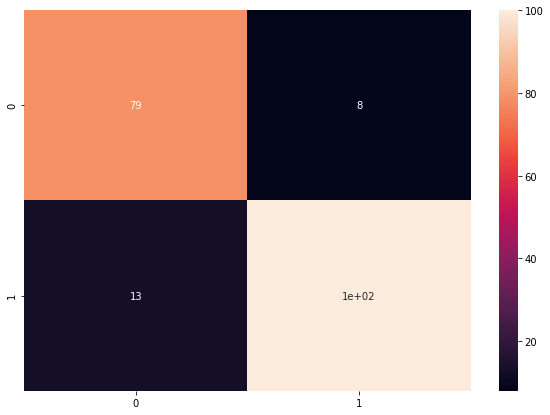

In [24]:
# plotting the confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [25]:
# generating the precision, recal and f1-score values for error indentification
target_names = ['Negative Error', 'Positive Error']
print(classification_report(actual_errors, predict_errors, target_names=target_names, digits=4))

                precision    recall  f1-score   support

Negative Error     0.8587    0.9080    0.8827        87
Positive Error     0.9259    0.8850    0.9050       113

     micro avg     0.8950    0.8950    0.8950       200
     macro avg     0.8923    0.8965    0.8938       200
  weighted avg     0.8967    0.8950    0.8953       200



In [26]:
# Calculating accuracy of the model
def percentage(part, whole):
  return 100 * float(part)/float(whole)

In [27]:
# calculating the overall accuracy of the model.
# overall accuracy = number of complete corrections / total number of inputs

print('Accuracy: {}'.format(percentage(correct_predictions , 200)))

Accuracy: 83.5


In [29]:
# total number of sentences which needs correction is equal to the number of sentences 
# which are actually having grammartical error
number_of_sentences_needed_correction = cm[1][0] + cm[1][1]

# number of accurate corrections made is equal to 
# number of correct predictions minus grammatically correct sentencesp
number_of_accurate_corrections_made = correct_predictions - cm[0][0]

print('Number of needed correcctions: {}'.format(number_of_sentences_needed_correction))
print('Number of accurate corrections made: {}'.format(number_of_accurate_corrections_made))
print('Accuracy of the corrections made: {}'.format(
    percentage(number_of_accurate_corrections_made , number_of_sentences_needed_correction))
     )

Number of needed correcctions: 113
Number of accurate corrections made: 88
Accuracy of the corrections made: 77.87610619469027
